In [33]:

import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
import yfinance as yf
import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.13.0
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [34]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = (2000, 12, 1)
start = datetime.datetime(*start) # * 튜플에서 값을 "하나씩 꺼내서" 전달함
end = datetime.date.today()

google = yf.download('028050.KS', start, end)
# if isinstance(google.columns, pd.MultiIndex):
#     google.columns = google.columns.droplevel(1) # 두번째 Column index level 삭제

print(google.head())
print(google.columns)

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open    Volume
Ticker        028050.KS    028050.KS    028050.KS    028050.KS 028050.KS
Date                                                                    
2000-12-01  1851.257080  1851.257080  1792.016854  1847.554566    222800
2000-12-04  1829.042114  1895.687373  1814.232057  1851.257201    196100
2000-12-05  1840.149658  1851.257201  1817.934572  1817.934572    158800
2000-12-06  1843.852295  1910.497559  1843.852295  1873.472412    287600
2000-12-07  1825.339478  1843.852048  1817.934449  1829.041992    147900
MultiIndex([( 'Close', '028050.KS'),
            (  'High', '028050.KS'),
            (   'Low', '028050.KS'),
            (  'Open', '028050.KS'),
            ('Volume', '028050.KS')],
           names=['Price', 'Ticker'])


In [35]:
print(google.columns.tolist())

[('Close', '028050.KS'), ('High', '028050.KS'), ('Low', '028050.KS'), ('Open', '028050.KS'), ('Volume', '028050.KS')]


Price   Ticker   
Close   028050.KS    0
High    028050.KS    0
Low     028050.KS    0
Open    028050.KS    0
Volume  028050.KS    0
dtype: int64


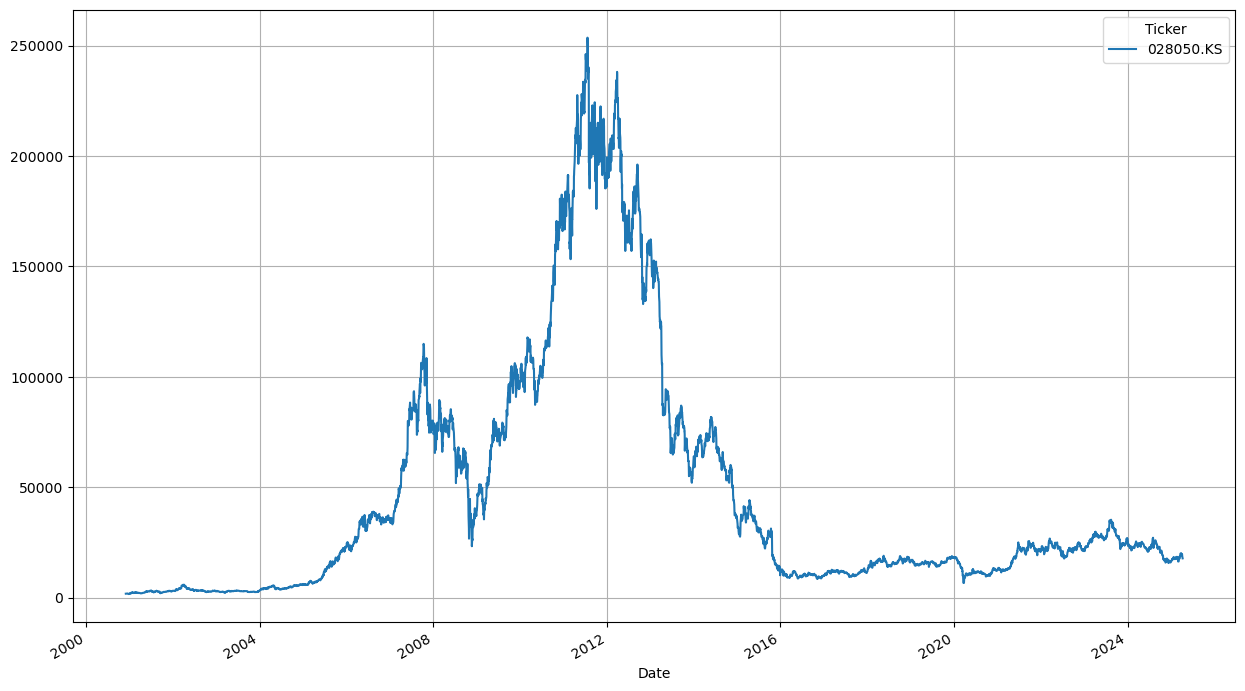

In [36]:
google.Low.plot(grid=True)
google.tail()
print(google.isna().sum())

In [ ]:
# Dataset : i번째 record 값을 주는 역할
# x_frames : 최근 n일
# y_frames : 이후 n일
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = yf.download('028050.KS', start, end)
        print(self.data.isna().sum())
    
    # 생성할 수 있는 Seq 개수
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    #i번째 데이터 요청이 왔을 때 i번째 데이터를 불러오는 역할
    def __getitem__(self, idx):
        idx += self.x_frames
        # idx 기준 이전 x개, 이후 y개
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close','Adj Close', 'Volume']]
        
        # (log(x+1) - log(x_ref+1)): 기준 시점(x_frames-1) 대비 변화율을 의미.
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        # numpy.ndarray로 변환
        data = data.values
        X = data[:self.x_frames] # 자른 앞쪽 : X
        y = data[self.x_frames:] # 자른 뒤쪽 : y
        
        return X, y
        

In [42]:
dataset = StockDataset('028050.KS', 10, 5, (2000,1,1), (2005,1,1))
dataset.data.iloc[0:2]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['028050.KS']: AttributeError("'tuple' object has no attribute 'timestamp'")


Price      Ticker   
Adj Close  028050.KS    0
Close      028050.KS    0
High       028050.KS    0
Low        028050.KS    0
Open       028050.KS    0
Volume     028050.KS    0
dtype: int64


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,028050.KS,028050.KS,028050.KS,028050.KS,028050.KS,028050.KS
Date,,,,,,


In [ ]:
class dummySet(Dataset):
    
    def __init__(self, num_data):
        self.x = np.array(list(range(num_data * 2))).reshape(-1,2)
        self.y = np.array(list(range(num_data)))

    def  __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]

In [ ]:
dataset = dummySet(100)
dataloader = DataLoader(dataset, 3, shuffle = True, drop_last=True)


In [ ]:
for X, y in dataloader:
    print(X.shape , y.shape)

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()

        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()

        def init_hidden(self):
            return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                    torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        
        def make_regressor(self):
            layers = []
            if self.use_bn:
                layers.append(nn.BatchNorm1d(self.hidden_dim))
            layers.append(nn.Dropout(self.dropout))

            layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
            layers.append(nn.ReLU())
            layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
            regressor = nn.Sequential(*layers)
            return regressor
        
        def forward(self, x):
            lstm_out, self.hidden = self.lstm(x, self.hidden)
            y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
            return y_pred


# x : [seq_len(n), batch_size(10), 5] 최근 n일
# y : [batch_size(10), m, 1] 이후 m일

